### [MTA_Subway_Trains_Delayed__Beginning_2020_20241117.csv](https://data.ny.gov/Transportation/MTA-Subway-Trains-Delayed-Beginning-2020/wx2t-qtaz/about_data)
Columns: 
- __month__: The month in which subway trains delayed is being calculated (yyyy-mm-dd).
- __division__: The A Division (numbered subway lines), B Division (lettered subway lines) and systemwide.
- __line__: Each subway line (1, 2, 3, 4, 5, 6, 7, A, C, E, B, D, F, M, G, J, Z, L, N, Q, R, W, S 42nd, S Rock, S Fkln).
- __day_type__: Represents weekday as 1 and weekend as 2.
- __reporting_category__: The six categories that delays are reported under: Infrastructure & equipment, Crew availability, Police & medical, External Factors, Operating conditions, Planned ROW work. 
- __subcategory__: The sub-categories that fall under the definition of Delays: Braking; Door-Related; Fire, Smoke, Debris; Inclement Weather; Crew Availability; Insufficient Supplement Schedule; Propulsion; Public Conduct, Crime, Police Response; Rail and Roadbed; Persons on Roadbed; Service Delivery; Sick/Injured Customer; Train Brake Activation - Cause Unknown; Subways Maintenance; Work Equipment; Capital Work - Other Planned ROW; External Debris on Roadbed; External Agency or Utility; Capital Work - Other Planned ROW; Other – CE; Other – Sig; Other Infrastructure; Other Internal Disruptions.
- __delays__: The number of train delays per category and time period.

### [MTA Subway Customer Journey-Focused Metrics: Beginning 2020](https://data.ny.gov/Transportation/MTA-Subway-Customer-Journey-Focused-Metrics-Beginn/4apg-4kt9/about_data)
- __month__: The month in which the metrics are being calculated (yyyy-mm-dd).

- __division__: The A Division (numbered subway lines and S 42nd) and B Division (lettered subway lines).

- __line__: Each subway line (1, 2, 3, 4, 5, 6, 7, A, C, E, B, D, F, M, G, JZ, L, N, Q, R, W, S 42nd, S Rock, S Fkln). A systemwide row also exists for each month in the dataset.

- __period__: Represents both the peak and off-peak service periods.

- __num_passengers__: Total number of passengers reported each month and on each line.

- __additional platform time__: The average additional time in minutes (above scheduled time) customers wait for their train, reported each month and on each line.

- __additional train time__: The average additional time in minutes (above scheduled time) customers spend onboard a train, reported each month and on each line.

- __total_apt__: The total number of additional time in minutes (above scheduled time) customers wait for their train, reported each month and on each line.

- __total_att__: The total number of average additional time in minutes (above scheduled time) customers spend onboard a train, reported each month and on each line.

- __over_five_mins__: The estimated total number of customers whose journeys are not completed within 5 minutes of the scheduled time, reported each month and on each line

- __over_five_mins_perc__: The estimated percentage of customers whose journeys are not completed within 5 minutes of the scheduled time, reported each month and on each line.

- __customer journey time performance__: The estimated percentage of customers whose journeys are completed within 5 minutes of the scheduled time, reported each month and on each line.


In [21]:
line_colors_shapes = {
    "1": "red",
    "2": "red",
    "3": "red",
    "4": "green",
    "5": "green",
    "6": "green",
    "7": "purple",
    "A": "blue",
    "C": "blue",
    "E": "blue",
    "B": "orange",
    "D": "orange",
    "F": "orange",
    "M": "orange",
    "G": "lightgreen",
    "J": "brown",
    "Z": "brown",
    "JZ": "brown",
    "L": "gray",
    "N": "gold",
    "Q": "gold",
    "R": "gold",
}

# Data Cleaning

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense
import matplotlib.pyplot as plt


# Load the dataset from the CSV file
file = 'MTA_Subway_Trains_Delayed__Beginning_2020_20241117.csv'
df = pd.read_csv(file)

# replace missing subcategories with reporting_category
df['subcategory'] = df['subcategory'].fillna(df['reporting_category'])

# replace "Other Operating Environment" with "Operating Conditions" to maintain parity
# a new "Service Management" subcategory was added in Aug 2024 which
# replaces the empty subcategory for "Operating Conditions"
df['subcategory'] = df['subcategory'].replace("Other Operating Environment", "Operating Conditions")

# drop the division and reporting_category columns, they are redundance info
df = df.drop(columns=['division', 'reporting_category'])

# remove S Rock, S Fkln, and GS (shuttles)
df = df[~df['line'].isin(['S Rock', 'S Fkln', 'GS'])]

df

In [ ]:
metrics_file = "MTA_Subway_Customer_Journey-Focused_Metrics__Beginning_2020_20241125.csv"
df_metrics = pd.read_csv(metrics_file)

# drop the division and 'customer journey time performance' columns, they are redundant info
df_metrics = df_metrics.drop(columns=['division', 'customer journey time performance'])


# remove S Rock, S Fkln, and S 42nd (shuttles) (and W since the delay data doesn't record it)
df_metrics = df_metrics[~df_metrics['line'].isin(['S Rock', 'S Fkln', 'S 42nd', "W"])]

# combine offpeak and peak metrics by multiplying each col by the number of passengers
# adding the 2 rows, then dividing by the total number of passengers for each col again
value_cols = [col for col in df_metrics.columns if col not in ["month", "division", "line", "period", "num_passengers"]]

for col in value_cols:
    df_metrics[col] *= df_metrics["num_passengers"]

# add rows with the same line and month
df_metrics = df_metrics.groupby(["month", "line"]).sum().reset_index()

# divide
for col in value_cols:
    df_metrics[col] /= df_metrics["num_passengers"]

# drop the period
df_metrics = df_metrics.drop(columns=['period'])

#sort by month 
df_metrics = df_metrics.sort_values(by=['month', 'line'])


# only keep the month, line, and a new col that sums total_att + total_apt
df_metrics = df_metrics[['month', 'line', 'total_apt', 'total_att']]
df_metrics['total_hrs_delayed'] = (df_metrics['total_apt'] + df_metrics['total_att']) / 60

# drop the total_apt and total_att cols
df_metrics = df_metrics.drop(columns=['total_apt', 'total_att'])

df_metrics

# Data Reshaping

In [ ]:
# pivot the delay subcategory rows into columns
df = df.pivot(index=['month', 'day_type', 'line'], columns='subcategory', values='delays').fillna(0)

# add rows with the same month but different day type
df = df.groupby(['month', 'line']).sum()

# merge with the metrics
df = pd.merge(df, df_metrics, how='inner', on=['month', 'line'])

df_no_covid = df[df['month'] > '2021-06-01']

df = df.reset_index().drop(columns=['month'])
df_no_covid = df_no_covid.reset_index().drop(columns=['month'])

df


In [25]:
def split_df_all_lines(df, line_to_test):
    # temporarily split the data to test and train and then append the training data at the end
    df_train = df[df['line'] != line_to_test]
    df_test = df[df['line'] == line_to_test]
    df = pd.concat([df_train, df_test])

    train_size = len(df) - len(df_test)

    # drop line
    df = df.drop(columns=['line'])

    #get the features and target
    features = np.array(df.drop(columns=['total_hrs_delayed']))
    target = np.array(df['total_hrs_delayed']).reshape(-1, 1)

    # normalize the data
    scaler = MinMaxScaler()
    scaled_features = scaler.fit_transform(features)
    scaled_target = scaler.fit_transform(target)

    # create sequences for the LSTM model
    step_size = 12
    X = []
    y = []
    for i in range(len(scaled_features) - step_size):
        X.append(scaled_features[i:i + step_size])
        y.append(scaled_target[i + step_size])

    X = np.array(X)
    y = np.array(y)

    # reshape to (samples, time steps, features)
    X = X.reshape(X.shape[0], X.shape[1], X.shape[2])

    # split the data into training and testing sets
    X_train = X[:train_size]
    X_test = X[train_size:]

    y_train = y[:train_size]
    y_test = y[train_size:]

    return X_train, X_test, y_train, y_test, scaler

In [26]:
def split_df_one_line(df, line):
    # temporarily split the data to test and train and then append the training data at the end
    df_line = df[df['line'] == line]
    
    # drop line
    df_line = df_line.drop(columns=['line'])

    #get the features and target
    features = np.array(df_line.drop(columns=['total_hrs_delayed']))
    target = np.array(df_line['total_hrs_delayed']).reshape(-1, 1)

    # normalize the data
    scaler = MinMaxScaler()
    scaled_features = scaler.fit_transform(features)
    scaled_target = scaler.fit_transform(target)

    # create sequences for the LSTM model
    step_size = 12
    X = []
    y = []
    for i in range(len(scaled_features) - step_size):
        X.append(scaled_features[i:i + step_size])
        y.append(scaled_target[i + step_size])

    X = np.array(X)
    y = np.array(y)

    # reshape to (samples, time steps, features)
    X = X.reshape(X.shape[0], X.shape[1], X.shape[2])

    # split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    return X_train, X_test, y_train, y_test, scaler
    
    

# LSTM Model

In [27]:
class LSTMResults:
    def __init__(self, y_pred_scaled, y_test_scaled, train_loss, test_loss, training_size, testing_size):
        self.y_pred_scaled = y_pred_scaled
        self.y_test_scaled = y_test_scaled
        self.train_loss = train_loss
        self.test_loss = test_loss
        self.training_size = training_size
        self.testing_size = testing_size
      
def lstm_model(X_train, X_test, y_train, y_test, scaler):
    # build the LSTM model
    model = Sequential()

    model.add(LSTM(units=64, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dense(units=1))


    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X_train, y_train, epochs=32, batch_size=32, validation_data=(X_test, y_test))

    # get the training and testing loss
    train_loss = model.history.history['loss']
    test_loss = model.history.history['val_loss']

    # predict the delays for the line left for testing
    y_pred = model.predict(X_test)

    # unscale the data
    y_pred_scaled = scaler.inverse_transform(y_pred)
    y_test_scaled = scaler.inverse_transform(y_test)
   
    return LSTMResults(
        y_pred_scaled,
        y_test_scaled,
        train_loss,
        test_loss,
        len(X_train),
        len(X_test)
    )



In [ ]:
lines_to_test = df['line'].unique()
num_lines = len(lines_to_test)

predictions_all_lines = {}
predictions_single_lines = {}
predictions_single_lines_after_covid = {}


for i, line_to_test in enumerate(lines_to_test):
    # predict the total hours delayed when using all lines
    X_train, X_test, y_train, y_test, scaler = split_df_all_lines(df, line_to_test)
    predictions_all_lines[line_to_test] = lstm_model(X_train, X_test, y_train, y_test, scaler)

    # predict the total hours when using only one line
    X_train, X_test, y_train, y_test, scaler = split_df_one_line(df, line_to_test)
    predictions_single_lines[line_to_test] = lstm_model(X_train, X_test, y_train, y_test, scaler)

    # try predicting without covid
    X_train, X_test, y_train, y_test, scaler = split_df_one_line(df_no_covid, line_to_test)
    predictions_single_lines_after_covid[line_to_test] = lstm_model(X_train, X_test, y_train, y_test, scaler)



In [29]:
nrows = 5
ncols = 4

def plot_predictions(predictions):
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(25, 30))

    for (key, value), i in zip(predictions.items(), range(num_lines)):
        ax_n = axs[i // ncols, i % ncols]

        ax_n.plot(value.y_pred_scaled, label='Predicted', color="black")
        ax_n.plot(value.y_test_scaled, label='Actual', color=line_colors_shapes[key], linestyle='dashed')

        ax_n.set_title(f'THD Prediction for the {key} line')
        ax_n.set_ylabel("THD")
        ax_n.set_xlabel("Months")
        ax_n.legend()

    plt.show()

def plot_evaluation(predictions):
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(25, 30))

    for (key, value), i in zip(predictions.items(), range(num_lines)):
        ax_n = axs[i // ncols, i % ncols]

        ax_n.plot(value.train_loss, label='Training Loss', color="blue")
        ax_n.plot(value.test_loss, label='Testing Loss', color="orange")

        ax_n.set_title(f'Model Loss for the {key} line')
        ax_n.set_ylabel("Loss")
        ax_n.set_xlabel("Epochs")
        ax_n.legend()
        

    plt.show()


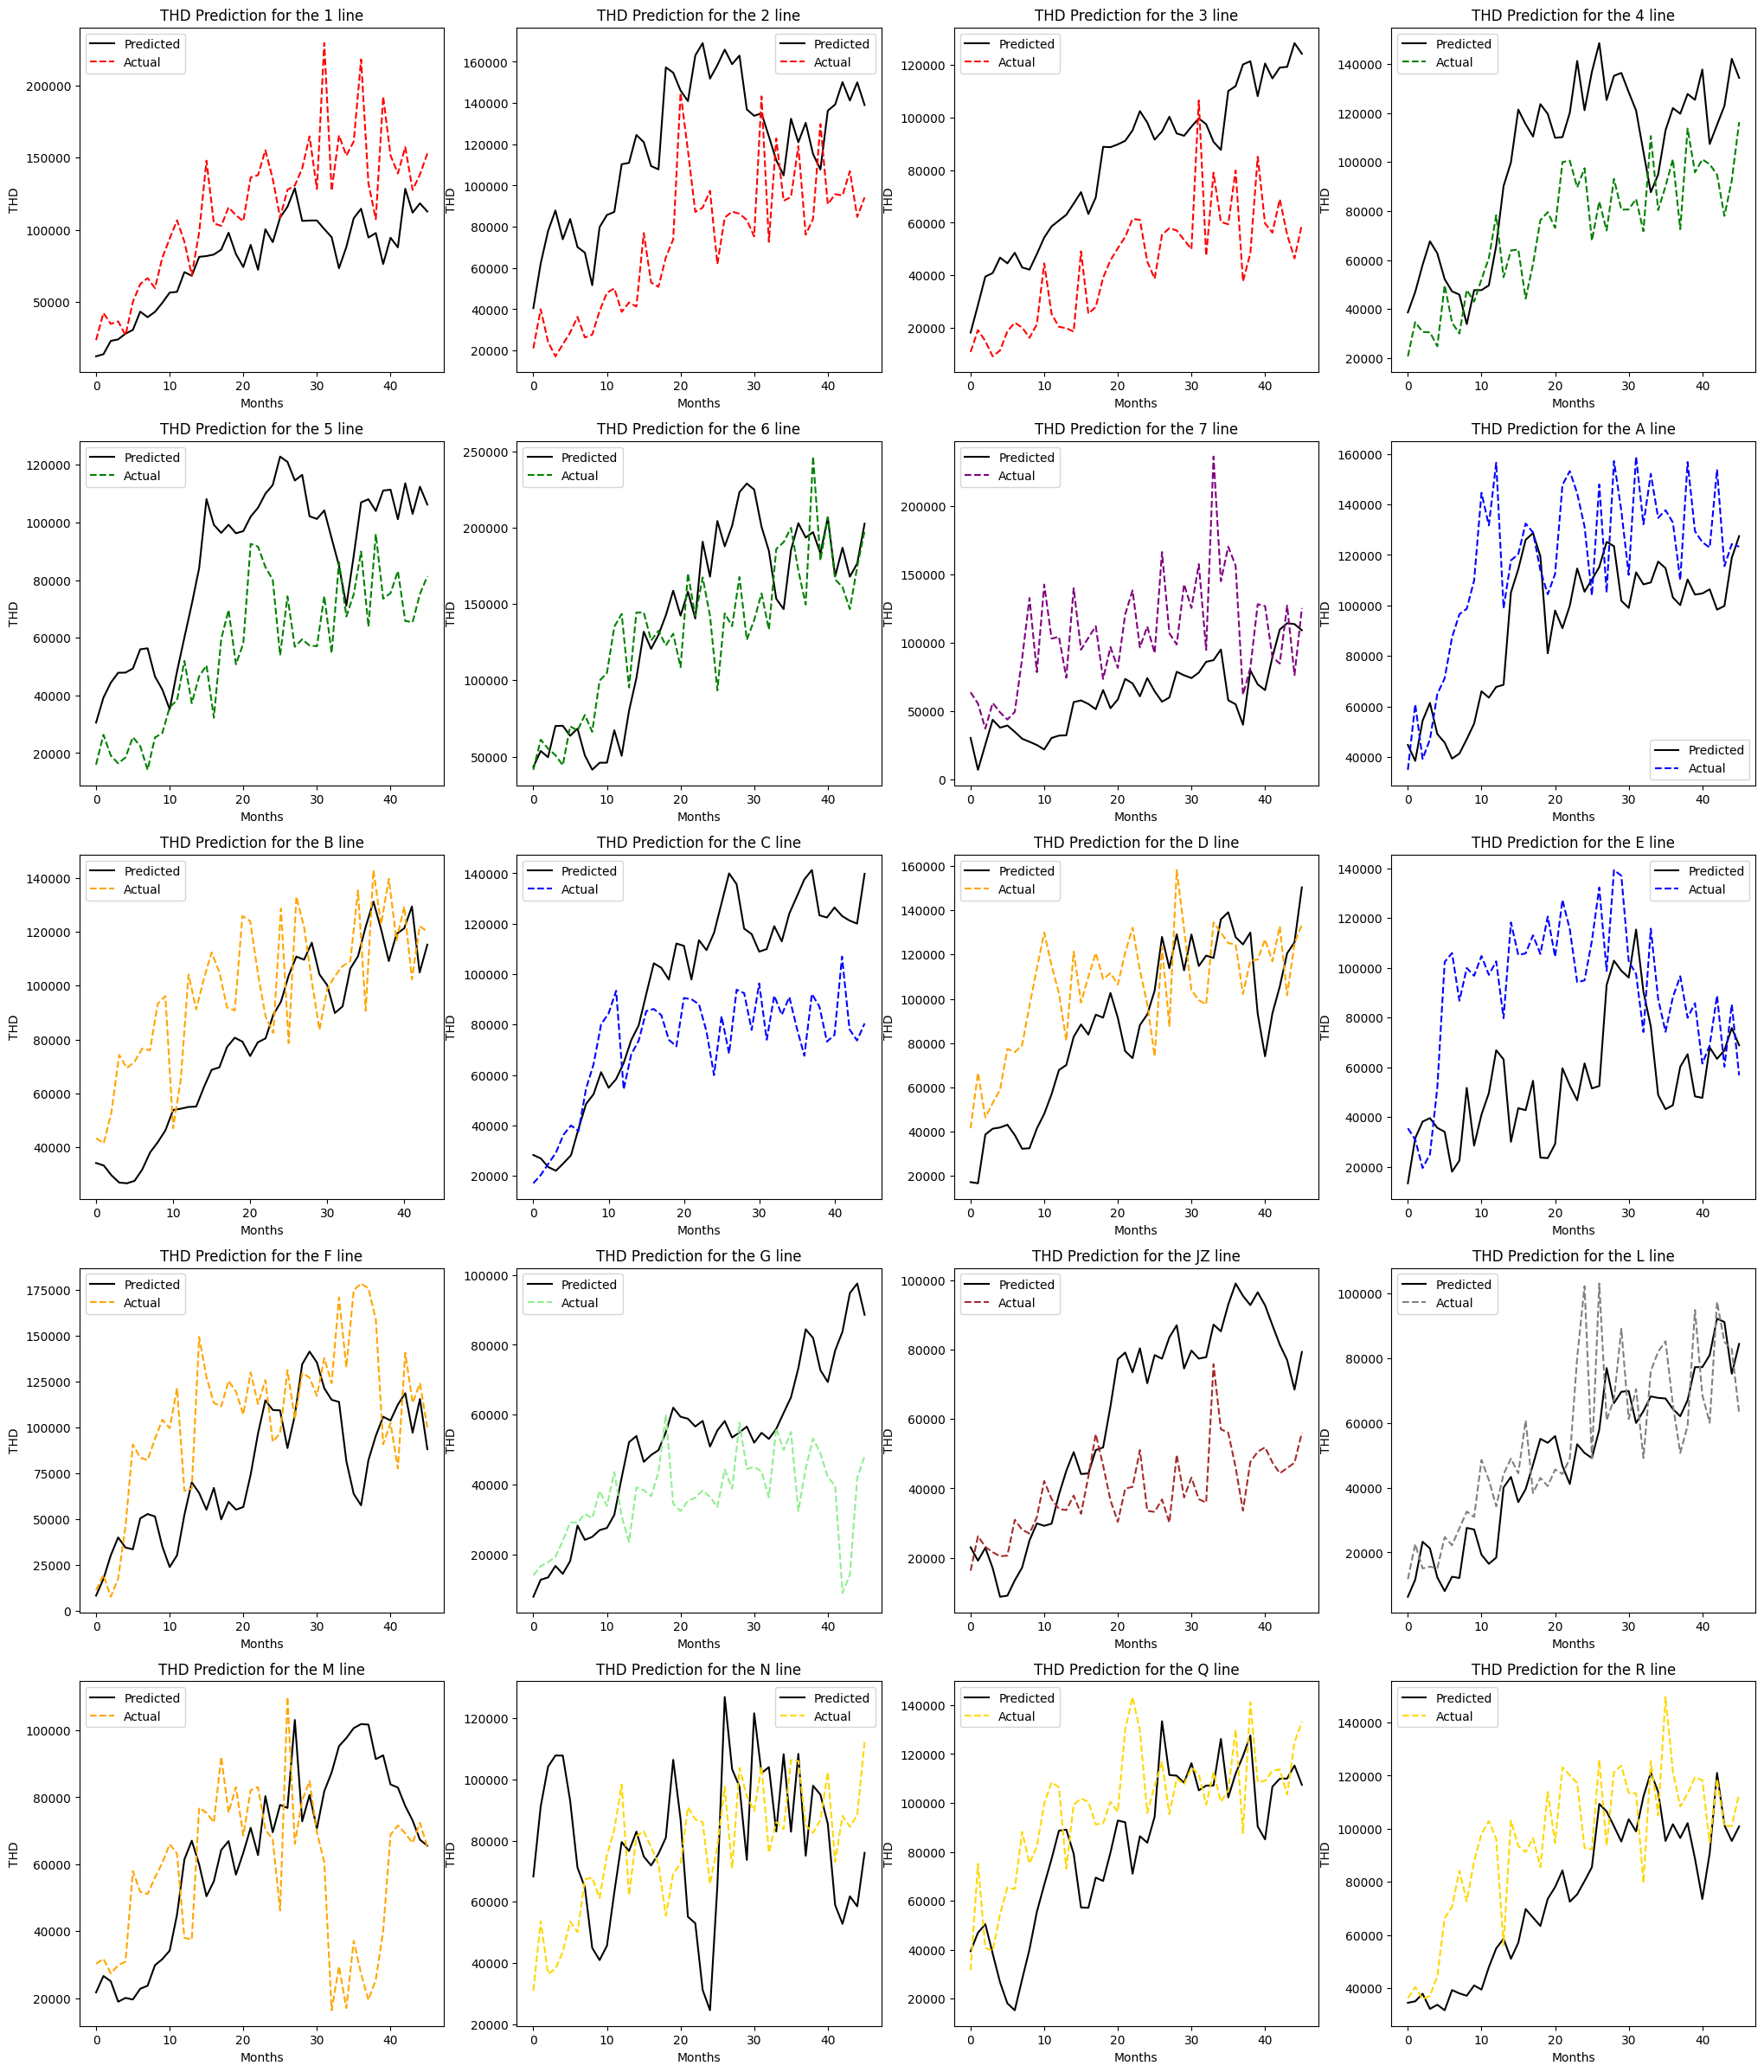

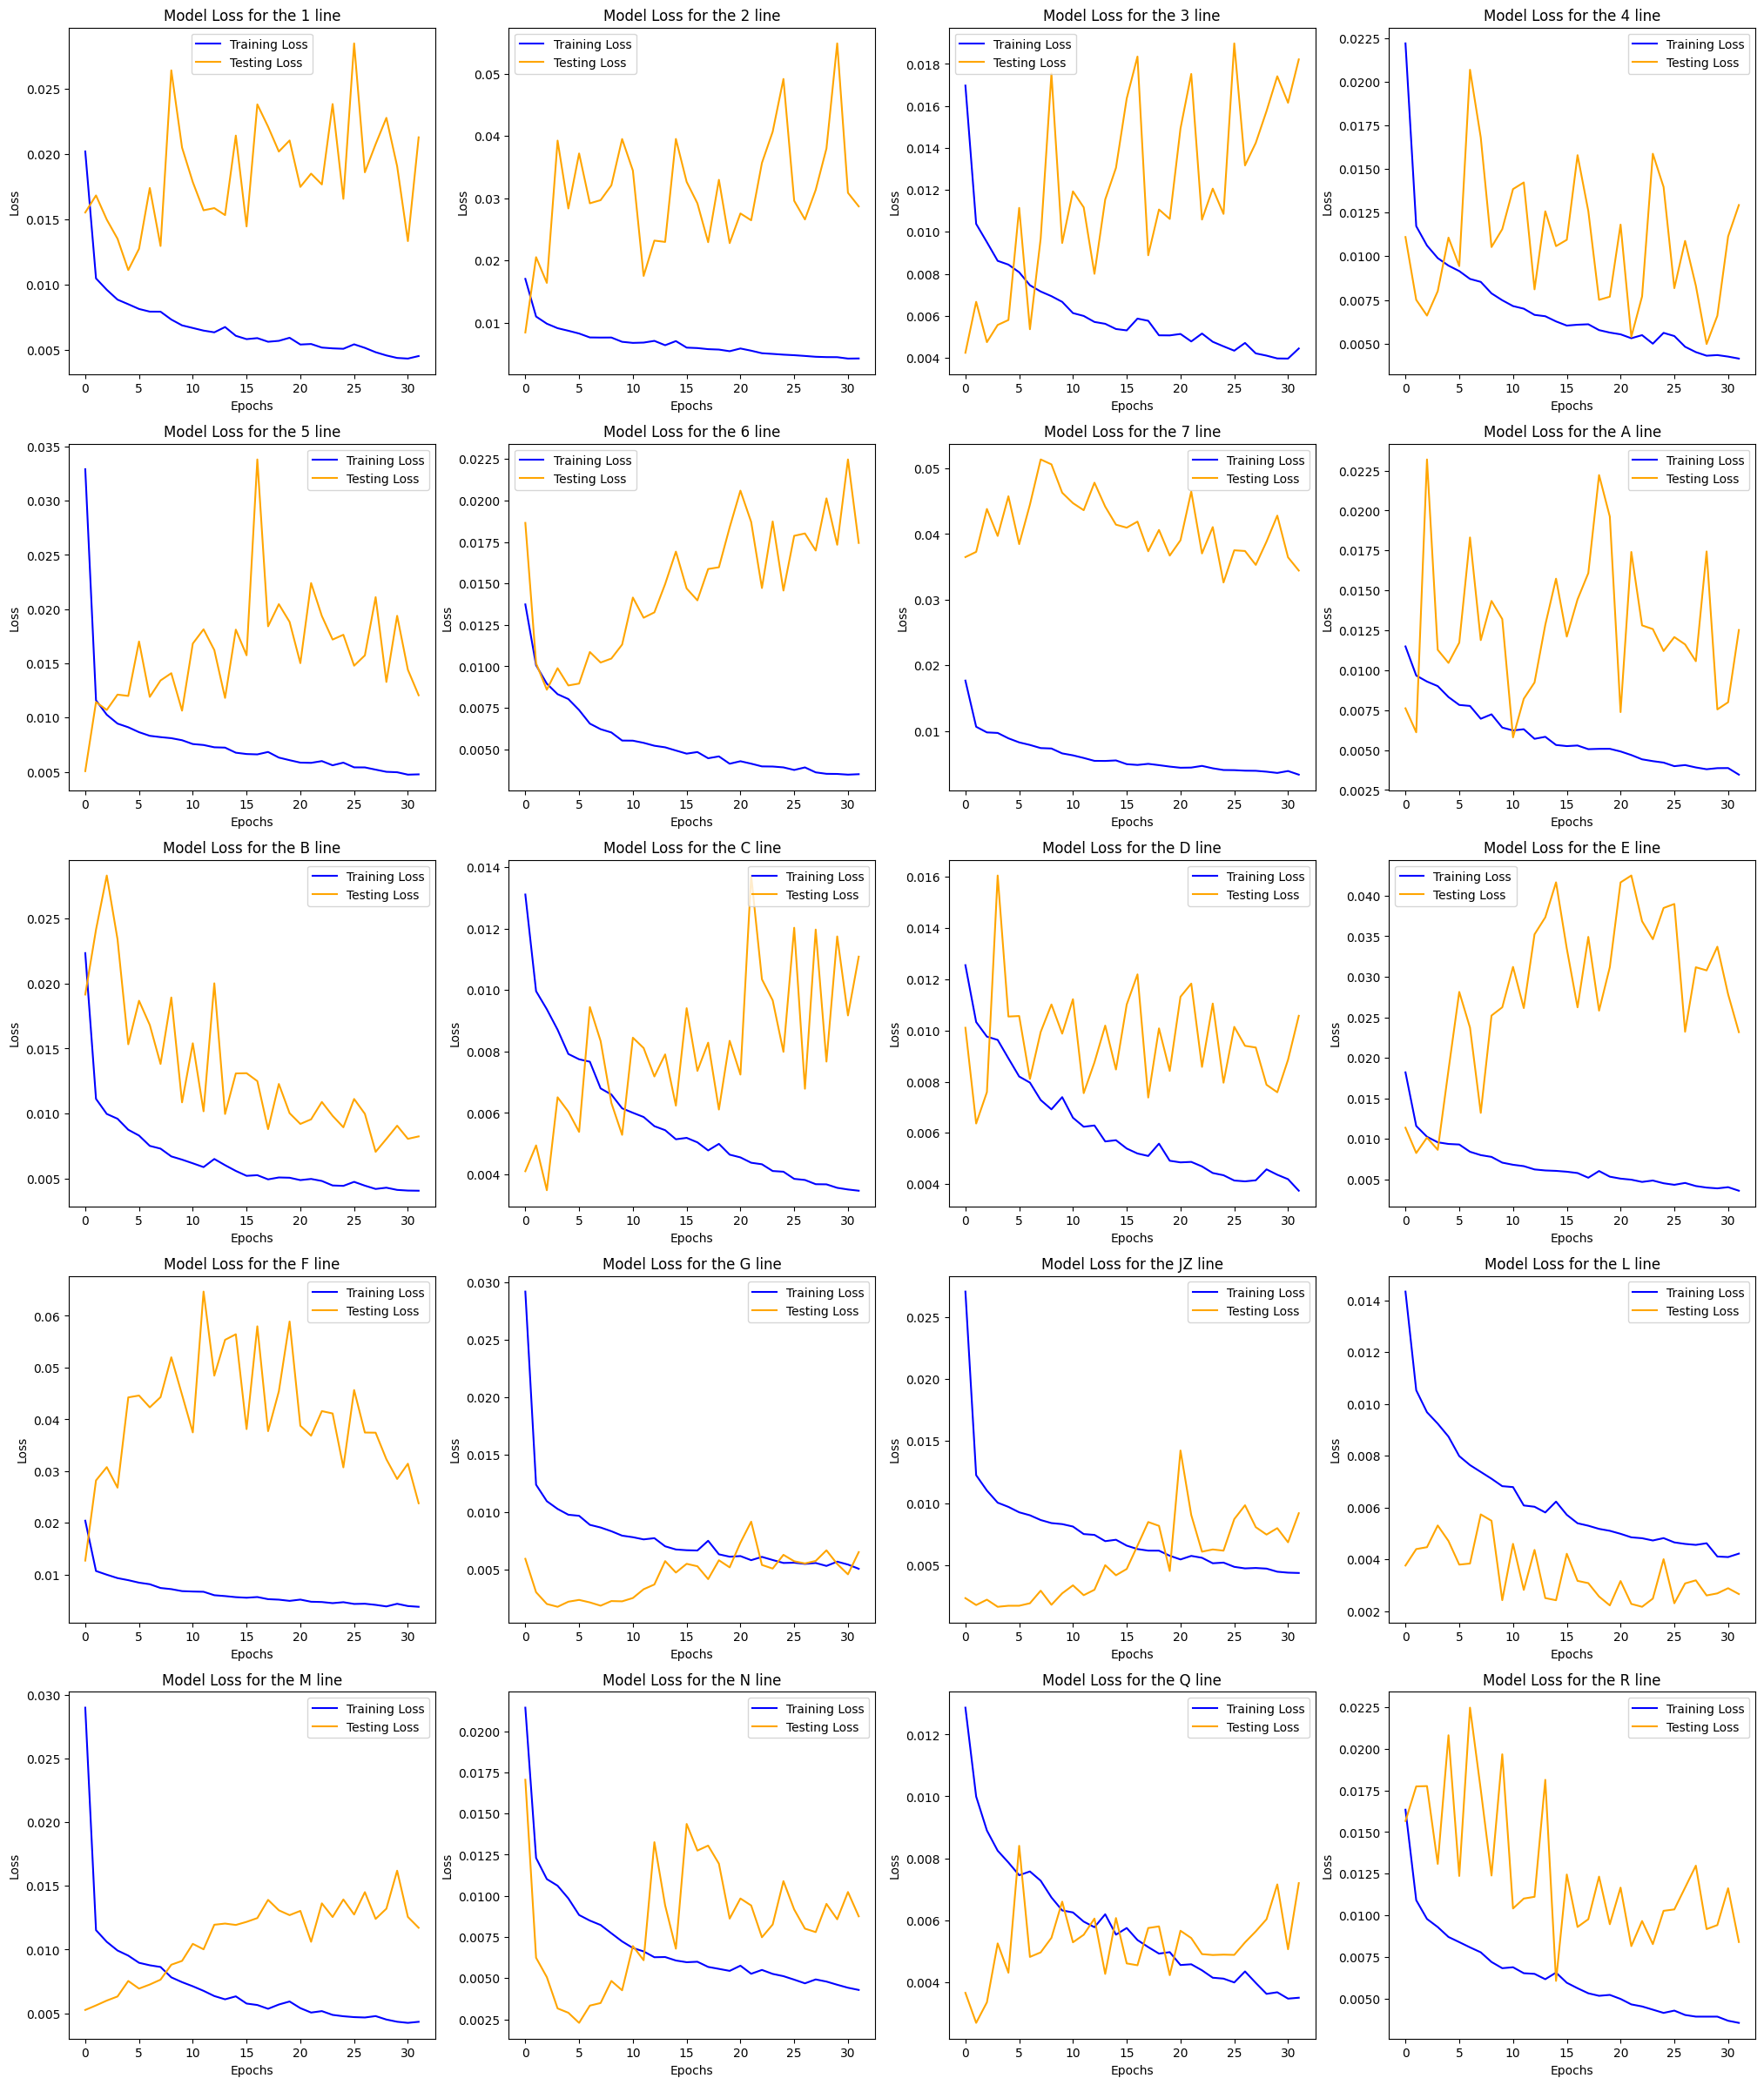

In [38]:
plot_predictions(predictions_all_lines)
plot_evaluation(predictions_all_lines)

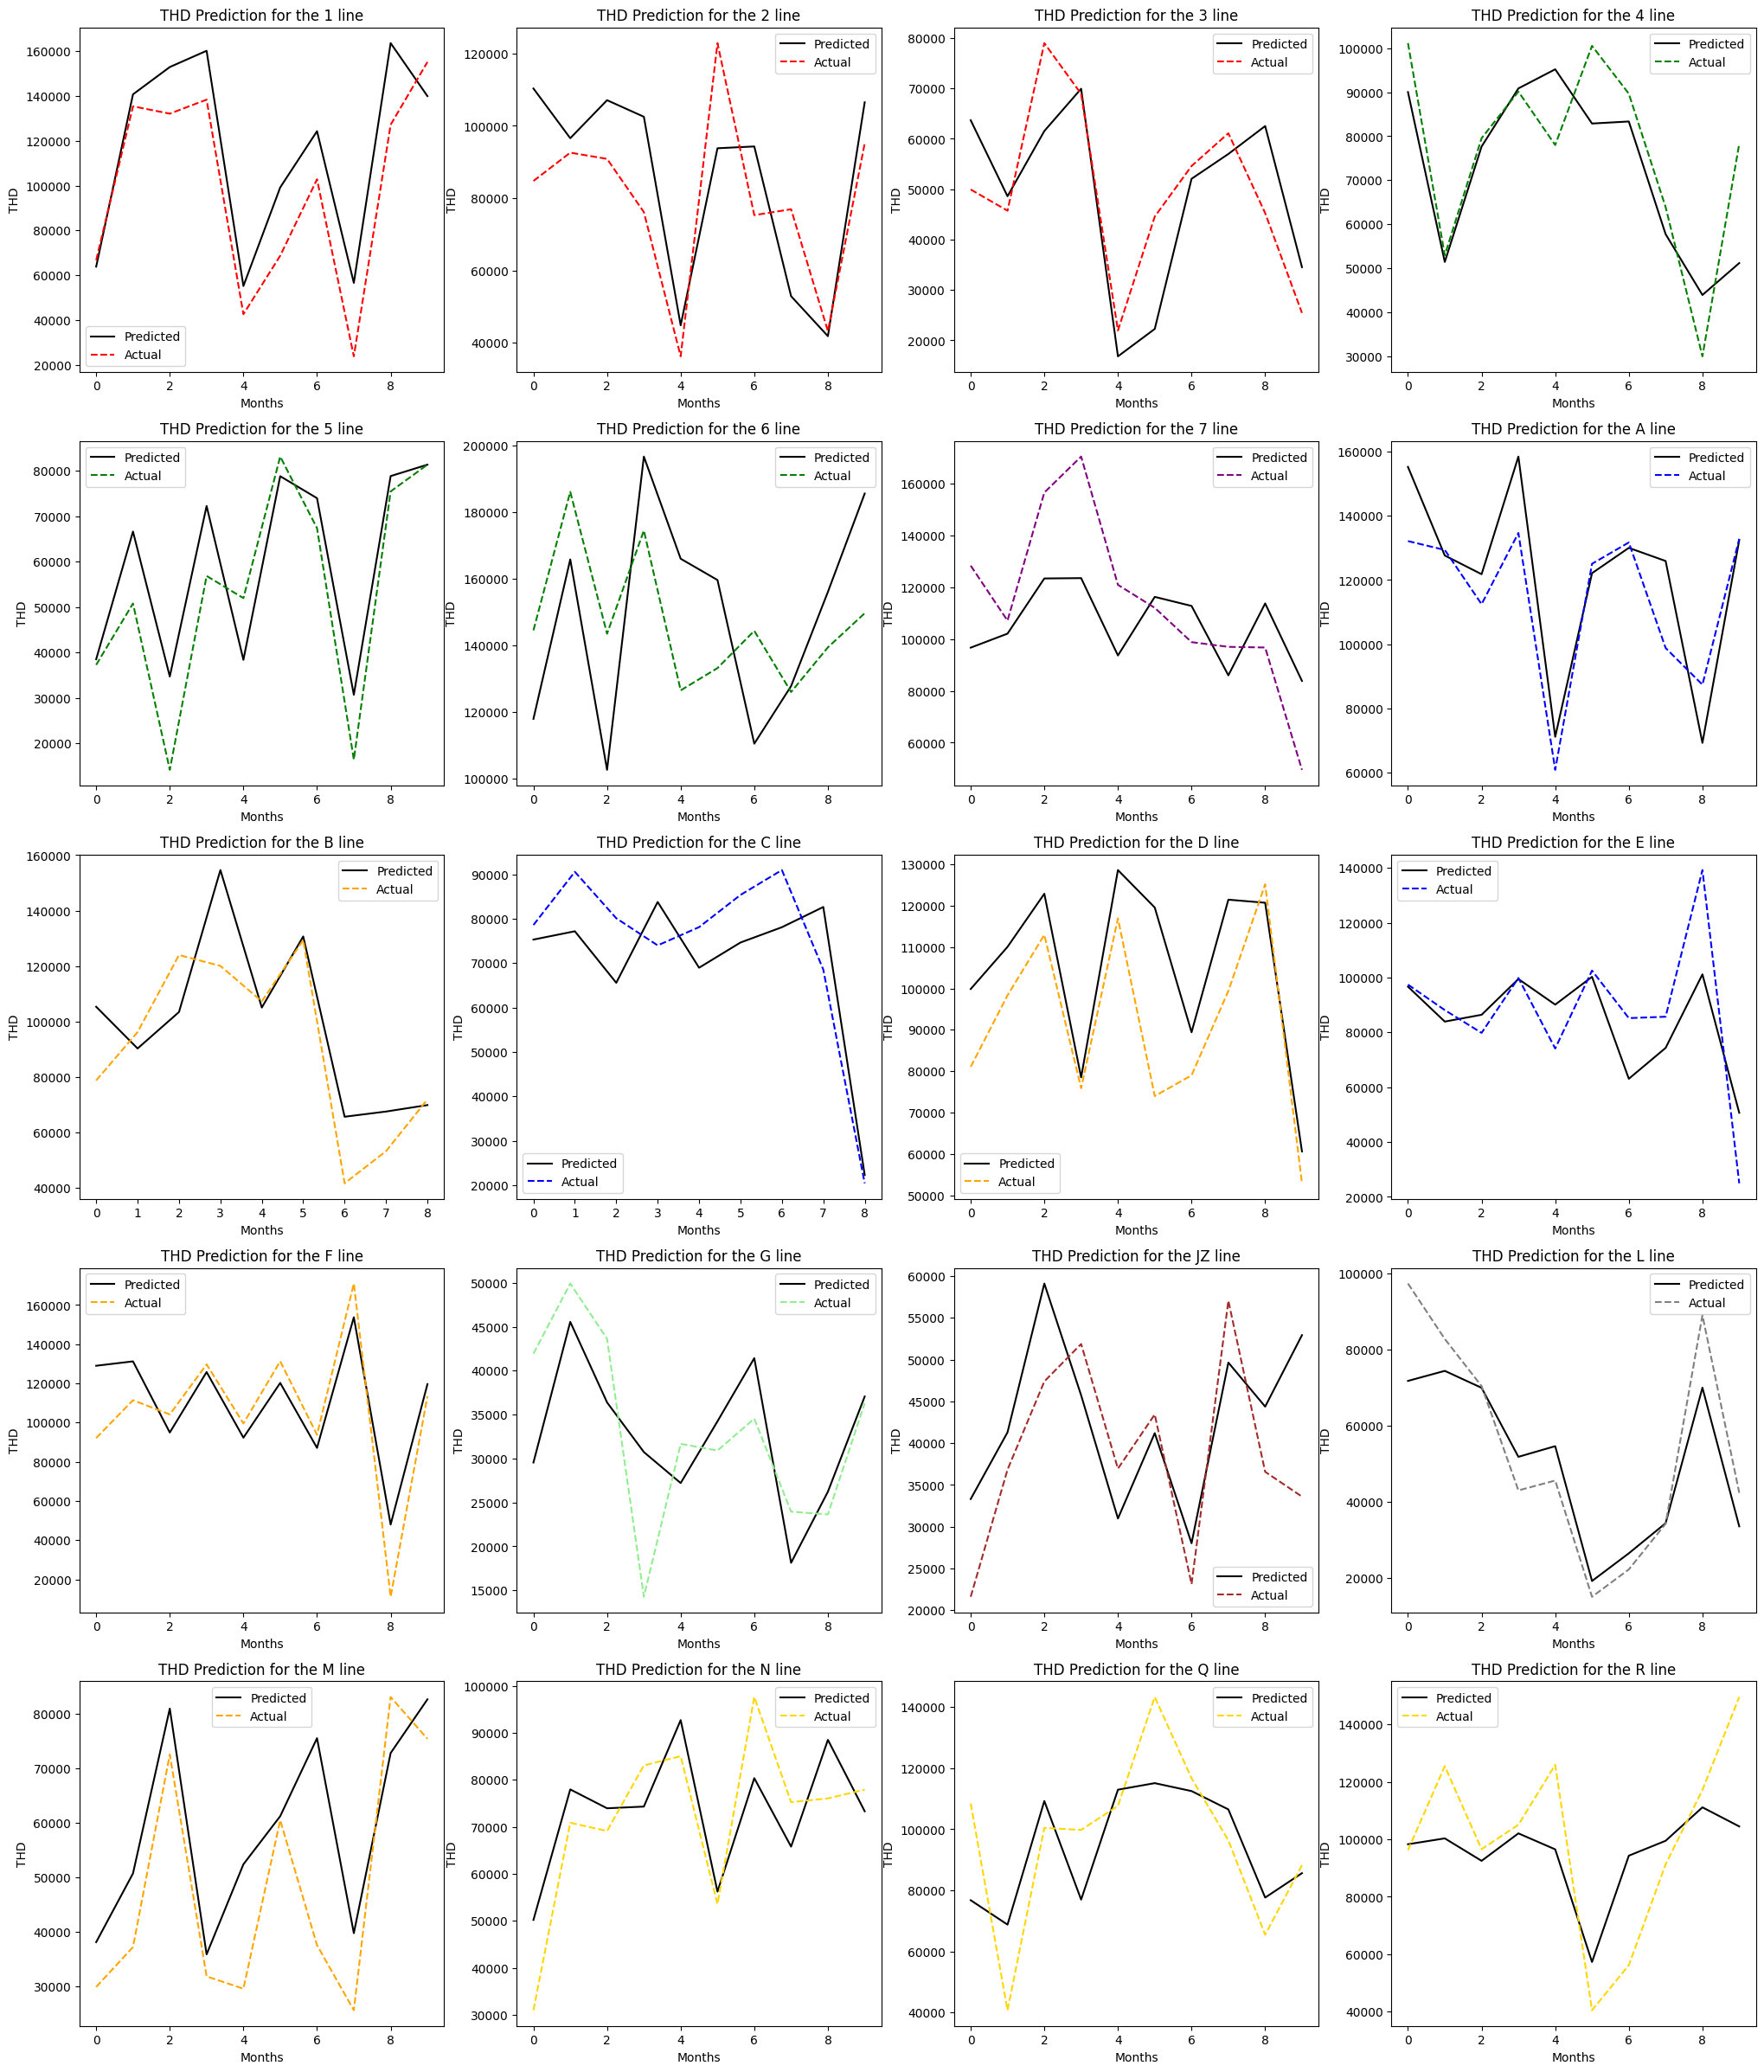

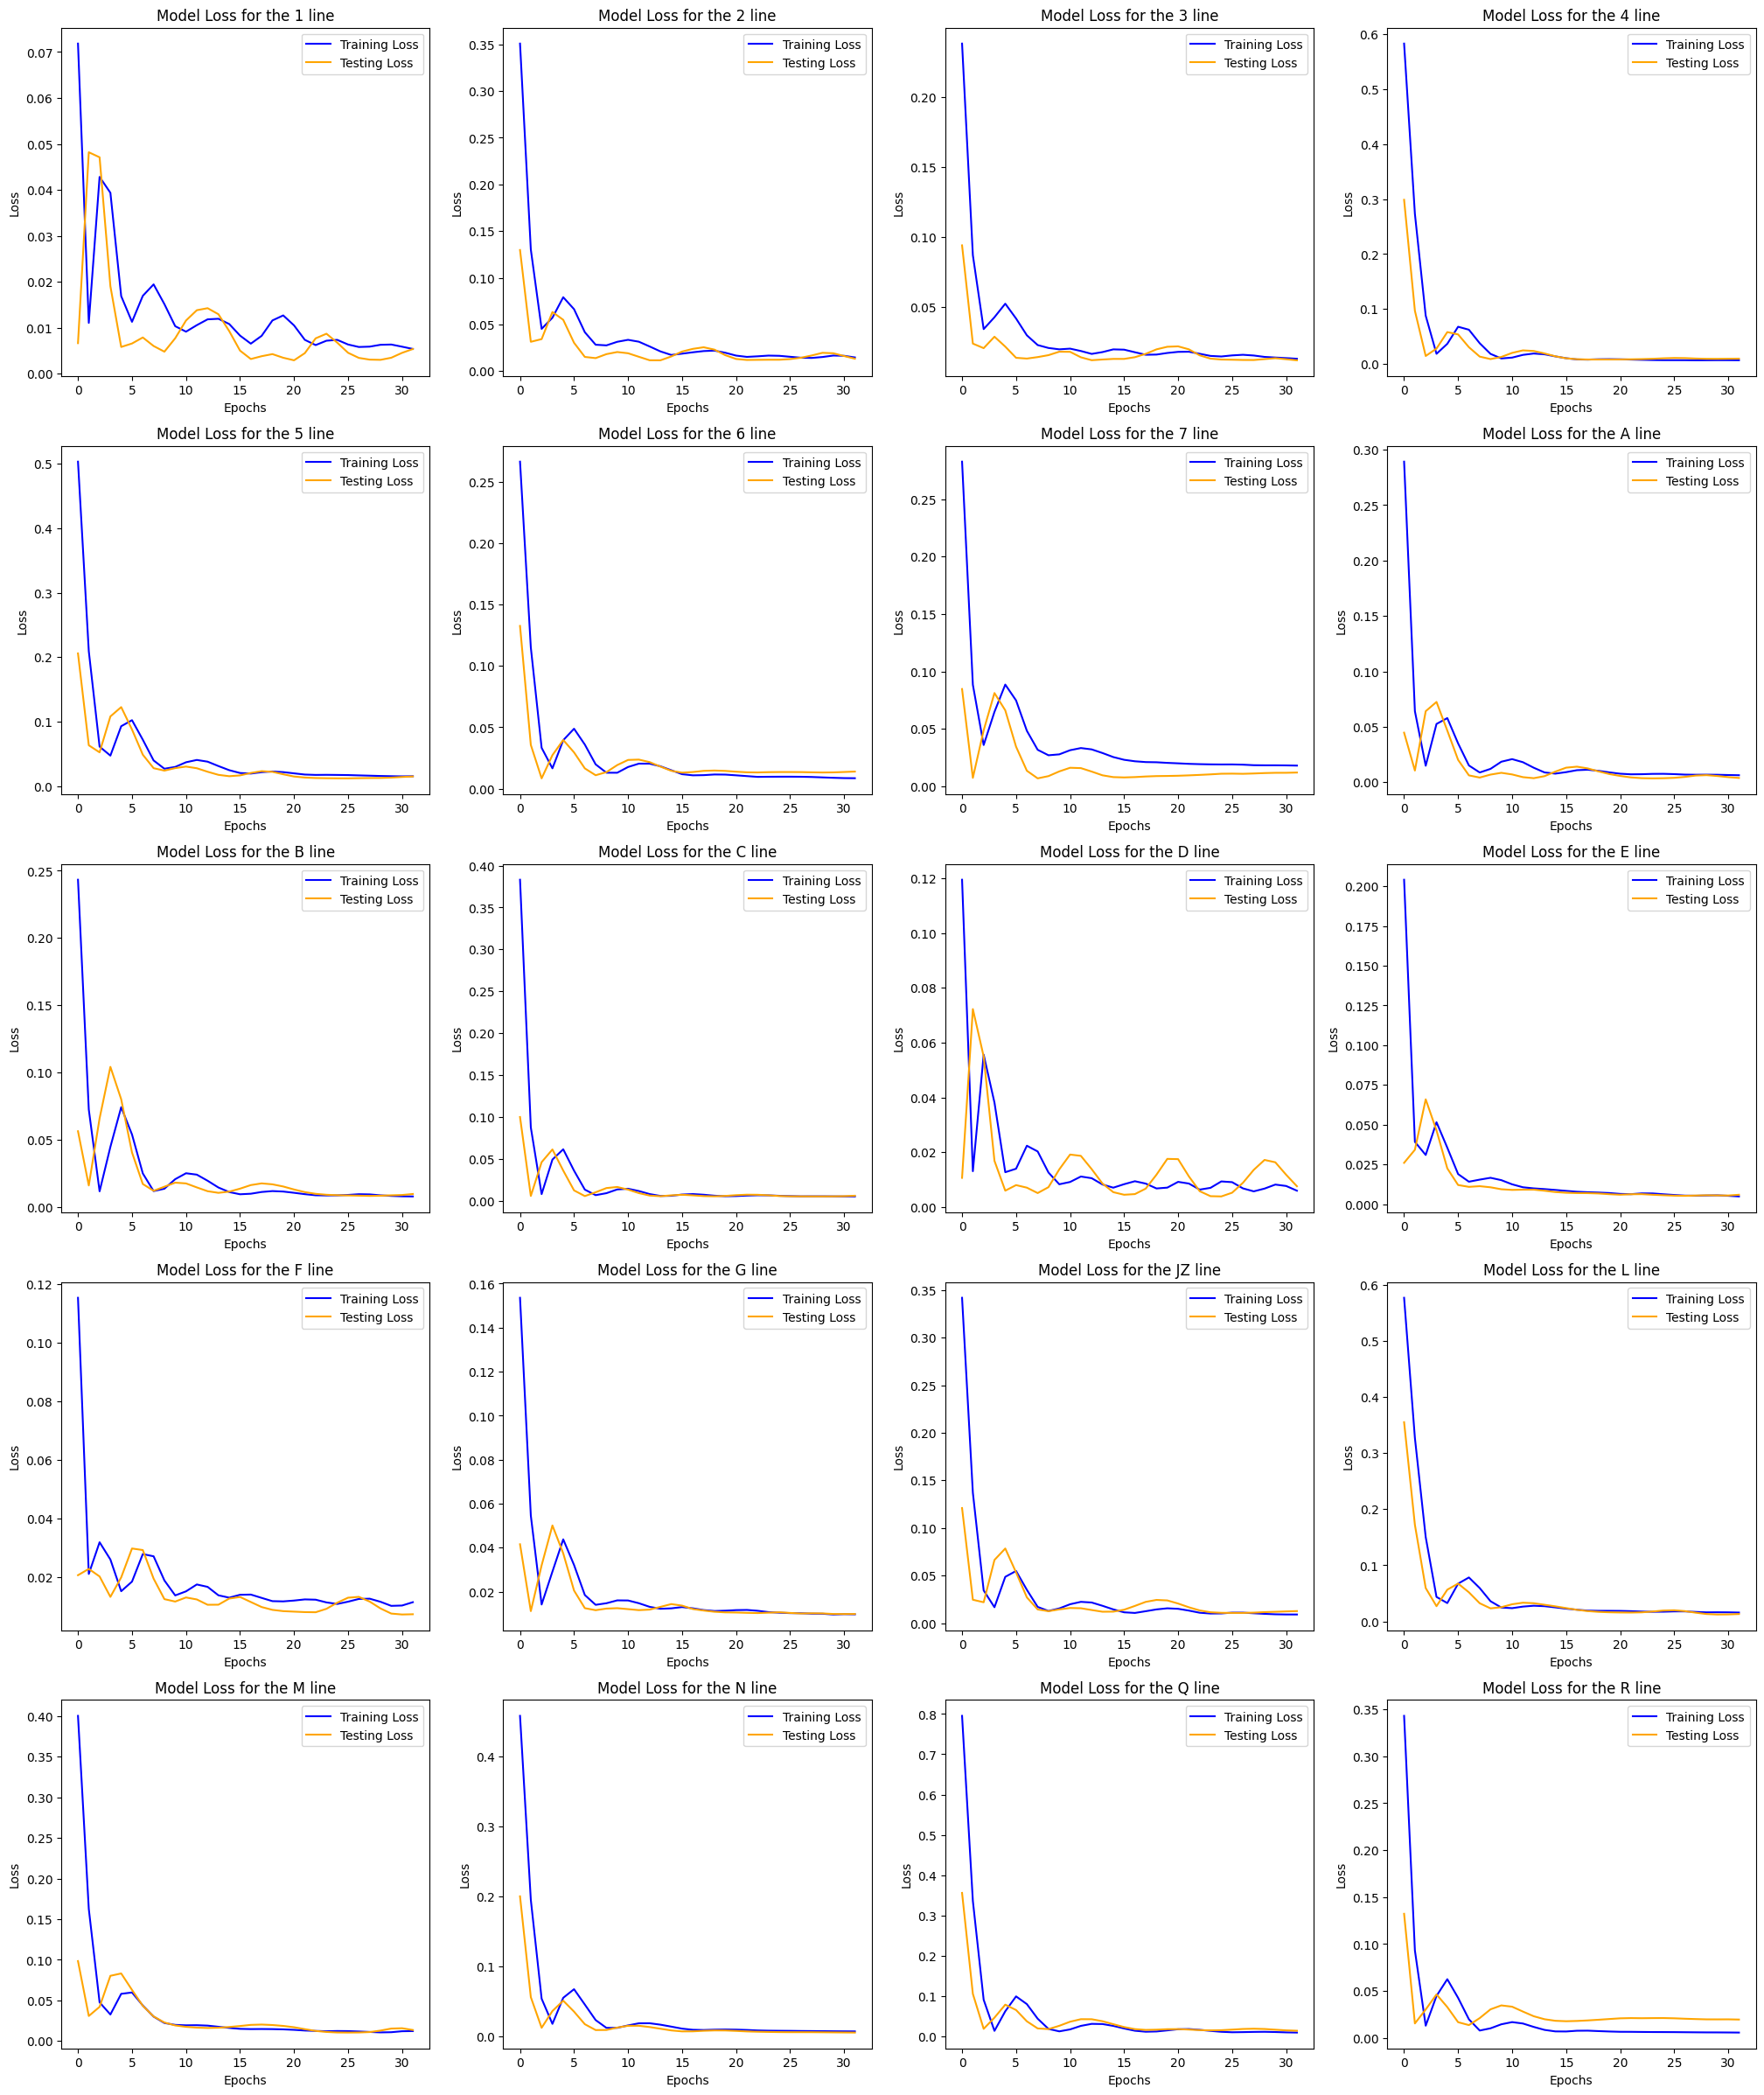

In [39]:
plot_predictions(predictions_single_lines)
plot_evaluation(predictions_single_lines)

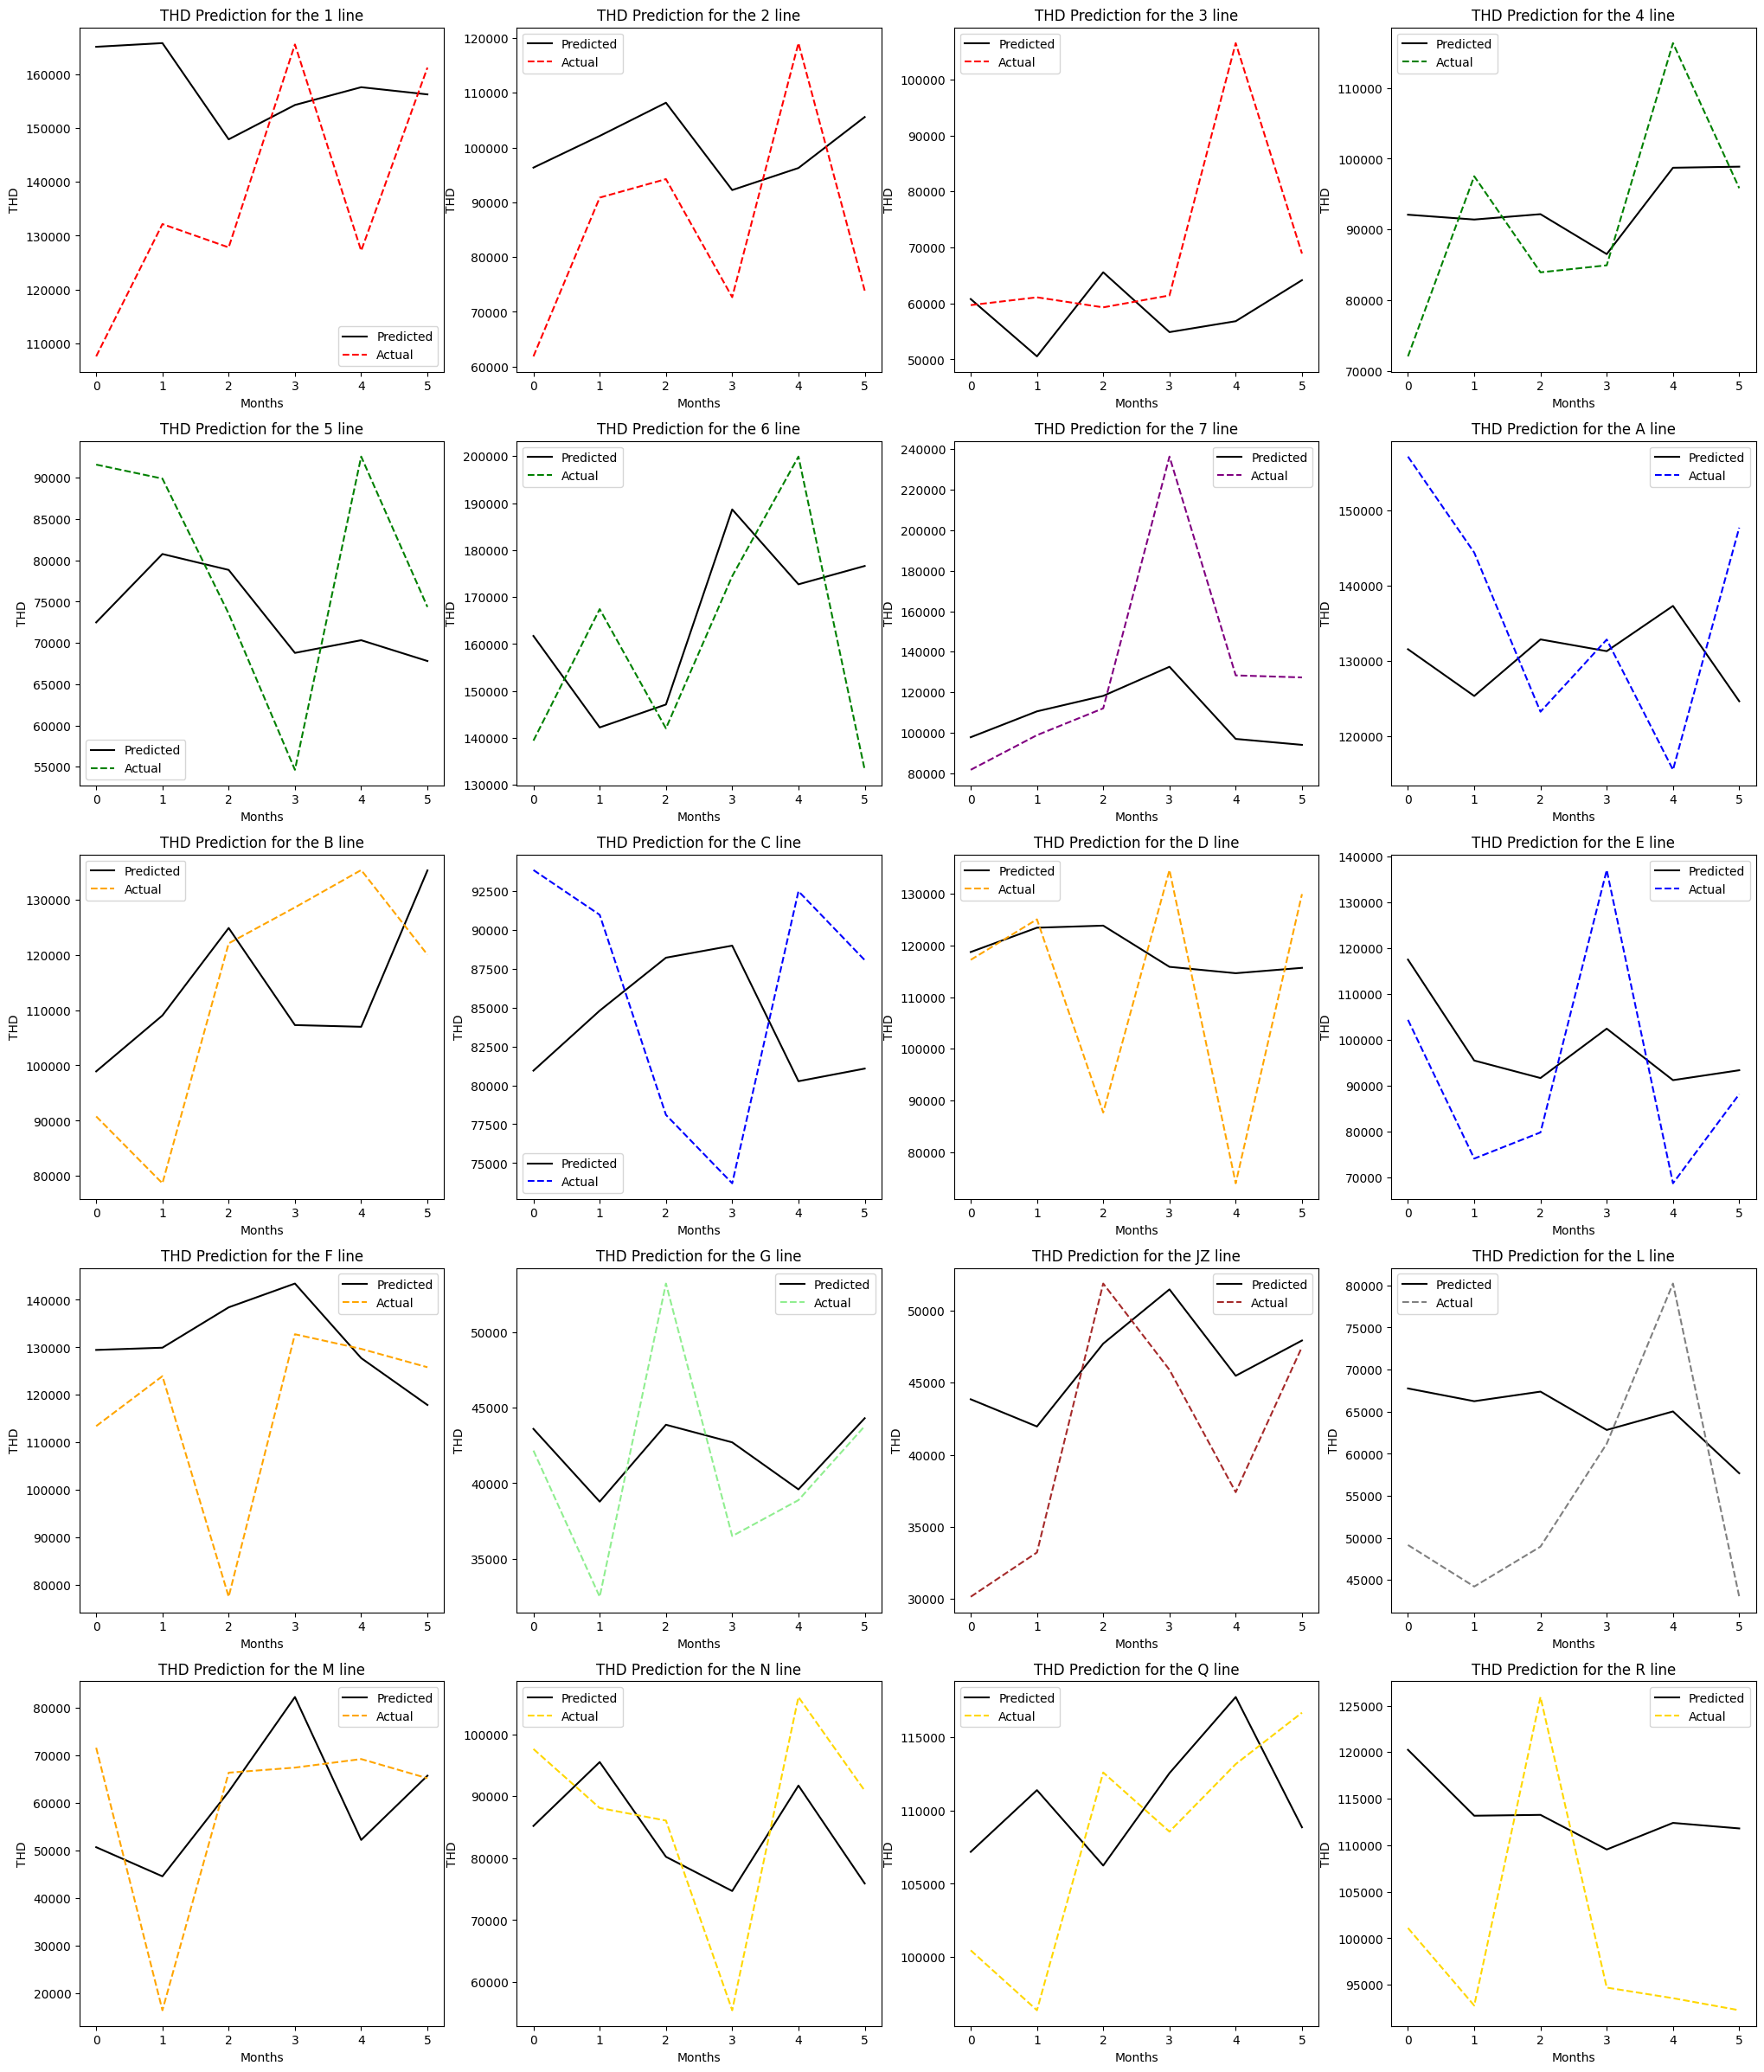

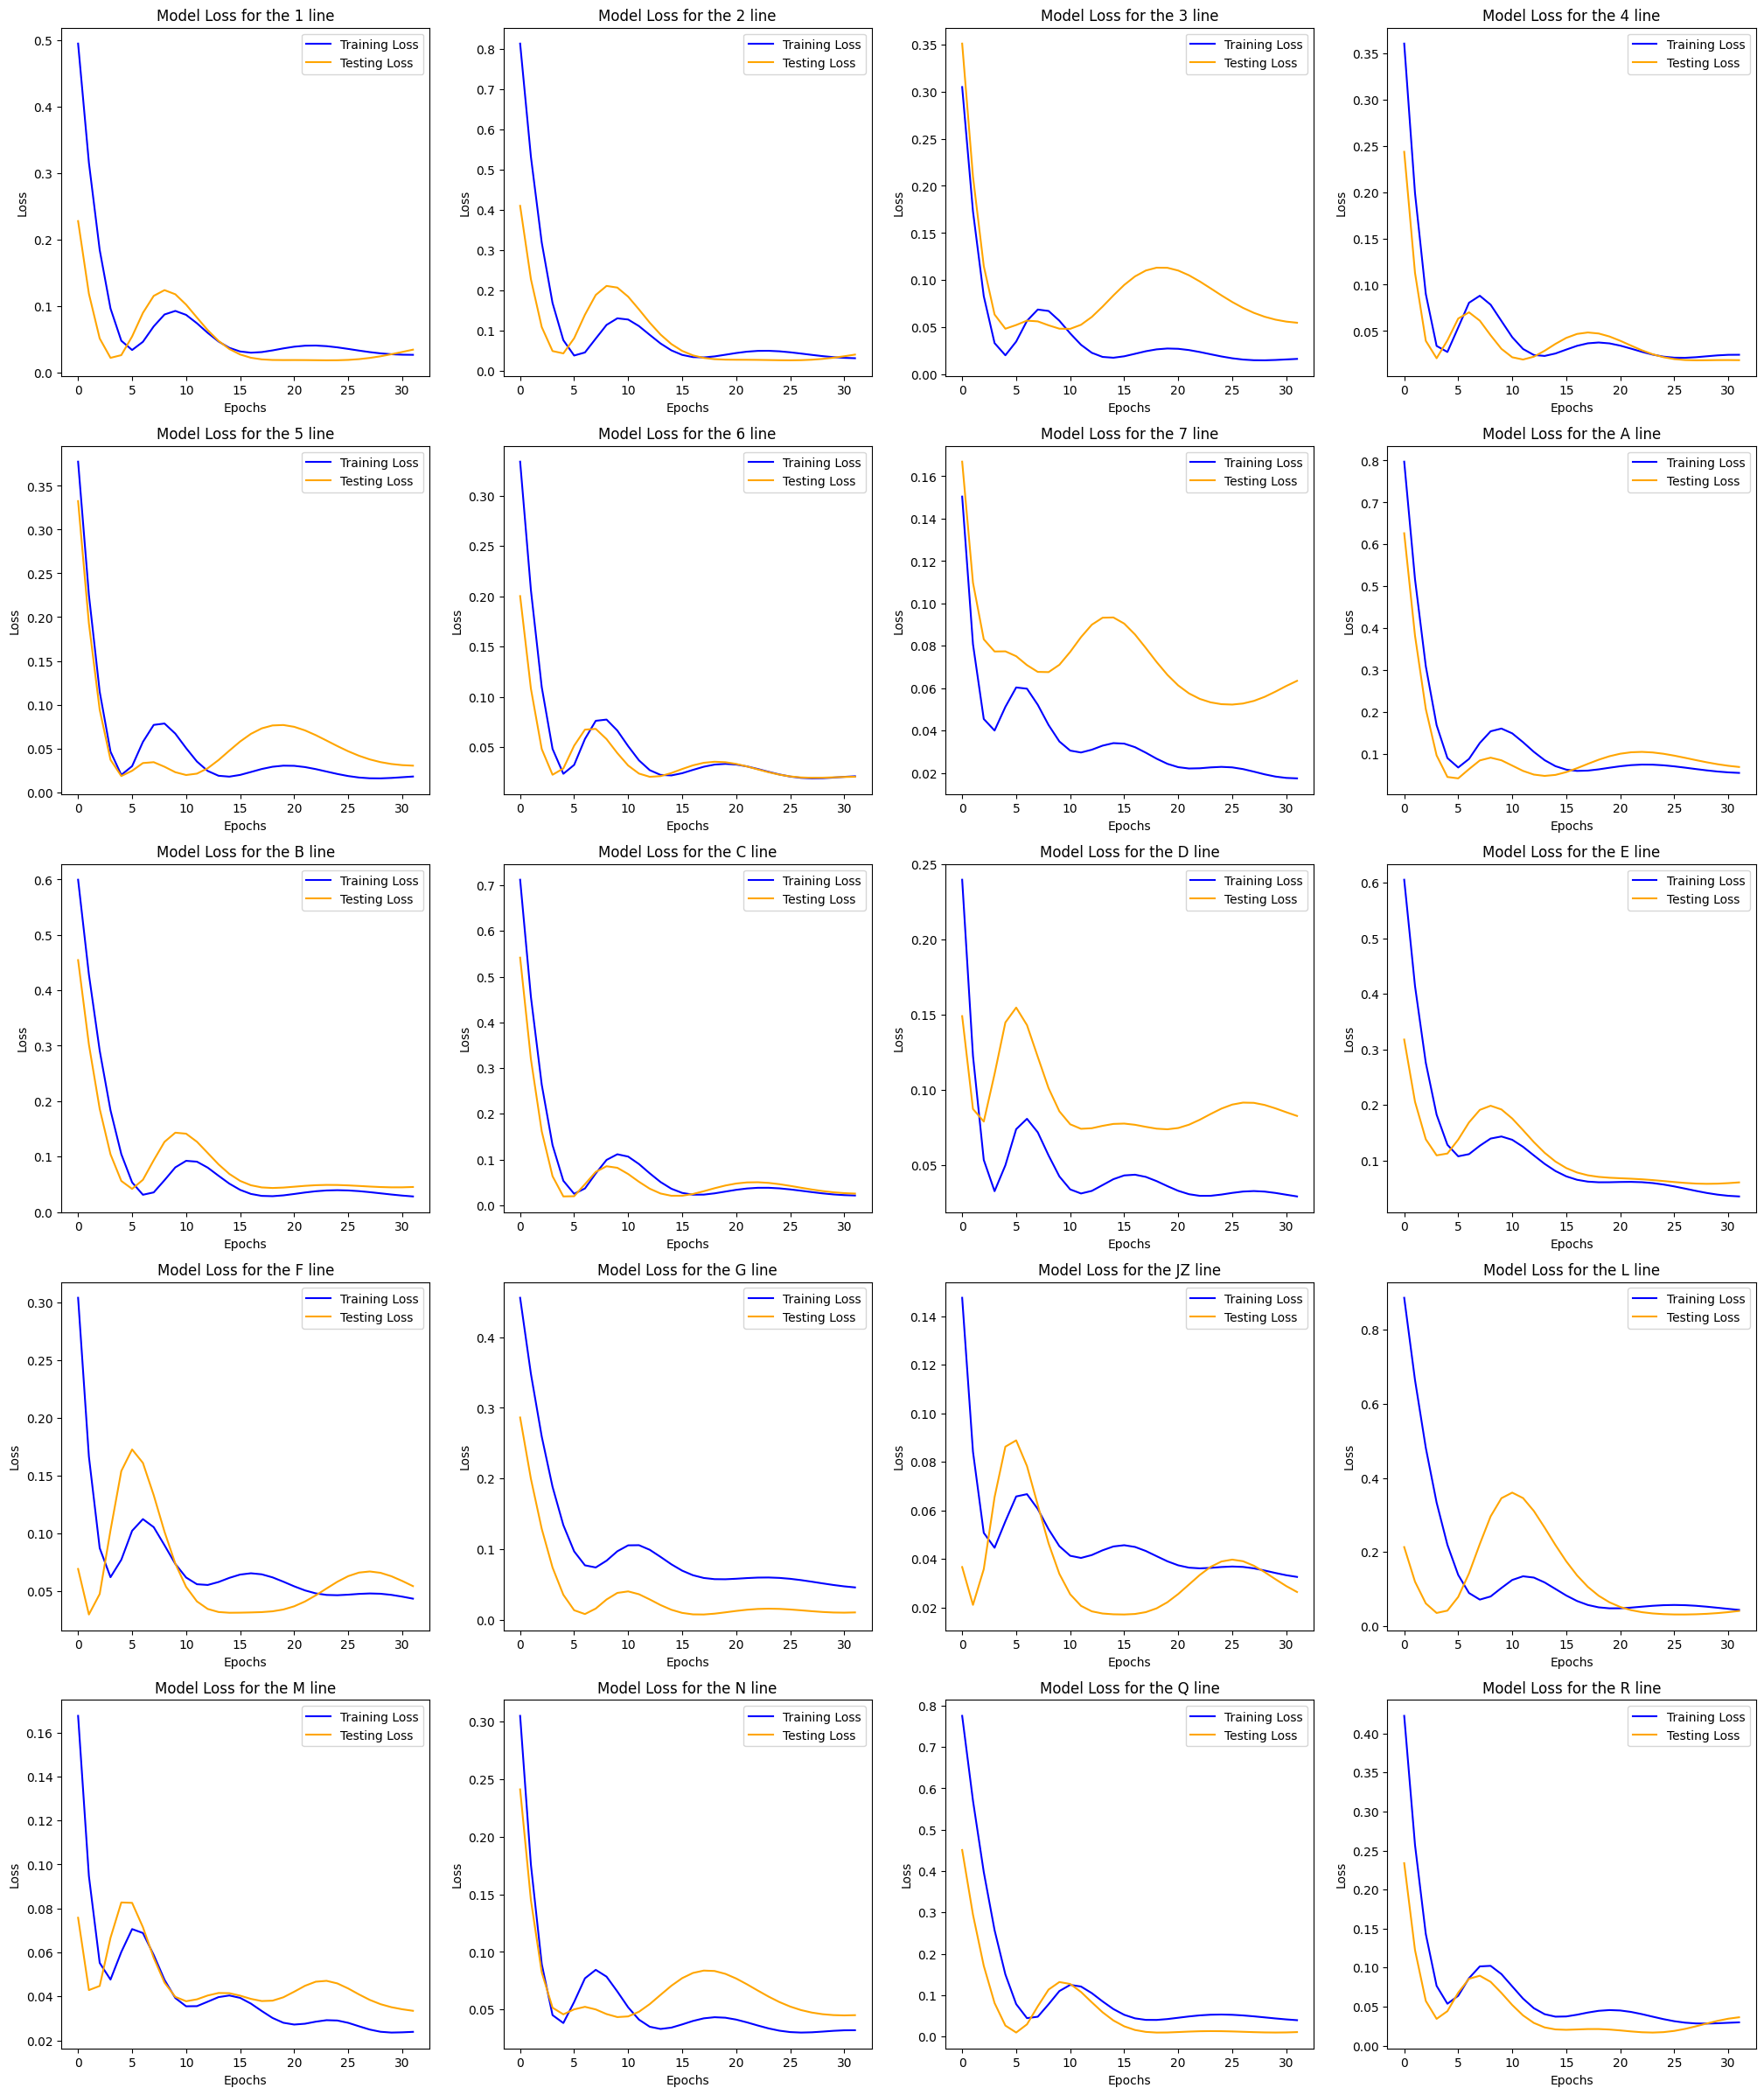

In [40]:
plot_predictions(predictions_single_lines_after_covid)
plot_evaluation(predictions_single_lines_after_covid)